# Vanilla Deep Q learning

**Algorithm: Vanilla Deep Q-learning**

---

Initialize replay memory D to capacity N

Initialize action-value function Q with random weights

**for** episode = 1, M **do**

&nbsp;&nbsp;&nbsp;&nbsp; Initialize sequence $s_{1} = \{x_{1}\}$ and preprocessed sequence $\phi_{1} = \phi(s_{1})$

&nbsp;&nbsp;&nbsp;&nbsp; **for** t = 1, T **do**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Select $a_{t} = \begin{cases} \max_{a}Q(\phi(s_{t}), a; \theta)&\text{with probability } 1-\epsilon \\ \text{random action }&\text{with probability } \epsilon \end{cases}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Execute action $a_{t}$ and observe reward $r_{t}$ and image $x_{t+1}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Set $s_{t+1}=s_{t}$, and preprocess $\phi_{t+1} = \phi(s_{t+1})$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Store transition ($\phi_{t}, a_{t}, r_{t}, \phi_{t+1}$) in D

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Sample random minibatch of transitions ($\phi_{j}, a_{j}, r_{j}, \phi_{j+1}$) from D

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Set $y_{j} = \begin{cases} r_{j}&\text{for terminal } \phi_{j+1} \\ r_{j} + \gamma \max_{a'} Q(\phi_{j+1}, a'; \theta)&\text{for non-terminal } \phi_{j+1} \end{cases}$


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Perform a gradient descent step on $(y_{j} - Q(\phi_{j}, a_{j};\theta))^{2}$

&nbsp;&nbsp;&nbsp;&nbsp; **end for**

**end for**

---


s = state, 

a = current action, 

a' = action for the next state, 

$\theta$ = parameters for the function approximator, 

$Q(s,a;\theta)$: action-value function estimated by a function approximator

In [1]:
import gym
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import random
import pickle
from collections import deque
from tqdm import tqdm
import matplotlib.pyplot as plt
import os.path
import copy
import torchvision.transforms as T
from PIL import Image
import time

In [2]:
class DQN_exp(): 
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.05):
        self.criterion = torch.nn.MSELoss()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(n_state, n_hidden), 
            torch.nn.ReLU(),
            torch.nn.Linear(n_hidden, n_action)
            )
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    def update(self, s, y):
        y_pred = self.model(torch.Tensor(s))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def predict(self, s):
        with torch.no_grad():
            result = self.model(torch.Tensor(s))
            return result

    def replay(self, memory, replay_size, gamma):
        if len(memory) >= replay_size:
            replay_data = random.sample(memory, replay_size) # draw random batch
            states = []
            td_targets = []
            for state, action, next_state, reward, is_done in replay_data:
                states.append(state) # states = later converted to predicted values Q(\phi_{j}, a_{j};\theta)
                q_values = self.predict(state).tolist() # approx q-value from NN
                
                if is_done:
                    q_values[action] = reward
                else:
                    q_values_next = self.predict(next_state)
                    q_values[action] = reward + gamma * torch.max(q_values_next).item() # q-value td update
                td_targets.append(q_values)
            self.update(states, td_targets) # gradient descent on (Q(\phi_{j}, a_{j};\theta), y_{j}) to update the weights(\theta) in the NN
    
    def gen_epsilon_greedy_policy(self, epsilon, n_action):
        def policy_function(state):
            if random.random() < epsilon:
                return random.randint(0, n_action - 1)
            else:
                q_values = self.predict(state)
                return torch.argmax(q_values).item()
        return policy_function

In [3]:
def q_learning(env, estimator, n_episode, replay_size, gamma=1.0, epsilon=0.1, epsilon_decay=0.99):
    for episode in tqdm(range(n_episode)):
        policy = estimator.gen_epsilon_greedy_policy(epsilon, n_action)
        state = env.reset()
        is_done = False

        while not is_done:
            action = policy(state)
            next_state, reward, is_done, _ = env.step(action)
            total_reward_episode[episode] += reward
            memory.append((state, action, next_state, reward, is_done))

            if is_done:
                break
            estimator.replay(memory, replay_size, gamma)
            state = next_state
        epsilon = max(epsilon * epsilon_decay, 0.01)

100%|██████████| 600/600 [07:57<00:00,  1.26it/s]
477


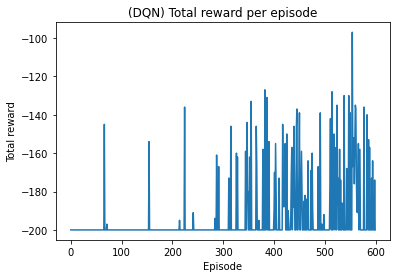

<Figure size 432x288 with 0 Axes>

In [4]:
backup_file = "DQN_MountainCar_" + time.strftime("%y%m%d") + "_1.p"
backup_check = os.path.isfile(backup_file)

if backup_check == True:
    with open(backup_file, "rb") as file:
        myEnv = pickle.load(file)
    total_reward_episode = myEnv["t_r_e"]
    duration = myEnv["duration"]

else:
    env = gym.envs.make("MountainCar-v0")
    n_state = env.observation_space.shape[0]
    n_action = env.action_space.n
    n_hidden = 50
    lr = 0.001
    dqn = DQN_exp(n_state, n_action, n_hidden, lr)
    memory = deque(maxlen=10000)
    n_episode = 600
    replay_size = 20

    total_reward_episode = [0] * n_episode
    start = time.time()
    q_learning(env, dqn, n_episode, replay_size, gamma=0.9, epsilon=0.3)
    end = time.time()
    duration = int(end - start)

    myEnv = dict()
    myEnv["t_r_e"] = total_reward_episode
    myEnv["duration"] = duration

    with open(backup_file, "wb") as file:
        pickle.dump(myEnv, file)

img_file = "DQN_MountainCar_" + time.strftime("%y%m%d") + ".png"
print(duration)
plt.plot(total_reward_episode)
plt.title("(DQN) Total reward per episode")
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.show()
plt.savefig(img_file)